# Web Scraping Stock Data

In [1]:
#import the basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#allow to use own functions from functions.py
import os
os.getcwd()

'C:\\Users\\Stijn\\Documents\\GitHub\\stock-scraping'

In [3]:
ticker = "ASML.AS"

In [ ]:
#TO DO:

In [ ]:
#summary
url_summary = "https://finance.yahoo.com/quote/"+ ticker + "?p=" + ticker + "&.tsrc=fin-srch"
url_summary

In [ ]:
#analysis by analysts
url_analists = "https://finance.yahoo.com/quote/" + ticker + "/analysis?p=" + ticker

In [ ]:
#sustainability
url_sust = "https://finance.yahoo.com/quote/" + ticker + "/sustainability?p=" + ticker

## Financials

In [4]:
from functions import income_statement

In [5]:
cf_abi=income_statement('ABI.BR', 'cash-flow')

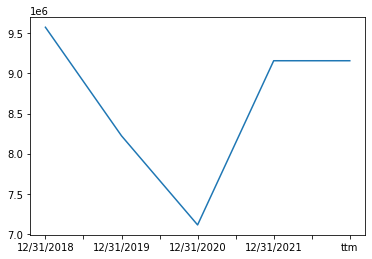

In [6]:
cf_abi['Free Cash Flow'].plot()
plt.show()

## Statistics

In [7]:
from functions import statistics

In [8]:
stat_googl = statistics('GOOGL')

In [9]:
stat_googl.head()

,parameter,value
0,Market Cap (intraday),1.44T
1,Enterprise Value,1.33T
2,Trailing P/E,19.71
3,Forward P/E,19.19
4,PEG Ratio (5 yr expected),0.77


## Historical Data

In [470]:
from functions import hist_stock_price

In [508]:
ASML_sp = hist_stock_price('AAPL')

In [509]:
ASML_sp[ASML_sp.Open == 0]

,Date,Open,High,Low,Close*,Adj Close**,Volume
17,2022-05-06,0.0,0.0,0.0,0.0,0.0,0
81,2022-02-04,0.0,0.0,0.0,0.0,0.0,0


In [513]:
ASML_sp.head(20)

,Date,Open,High,Low,Close*,Adj Close**,Volume
1,2022-05-27,137.39,146.35,145.26,146.29,146.29,6684688
2,2022-05-26,137.39,144.34,137.14,143.78,143.78,90501100
3,2022-05-25,138.43,141.79,138.34,140.52,140.52,92482700
4,2022-05-24,140.81,141.97,137.33,140.36,140.36,104132700
5,2022-05-23,137.79,143.26,137.65,143.11,143.11,117726300
6,2022-05-20,139.09,140.70,132.61,137.59,137.59,137194600
7,2022-05-19,139.88,141.66,136.60,137.35,137.35,136095600
8,2022-05-18,146.85,147.36,139.90,140.82,140.82,109742900
9,2022-05-17,148.86,149.77,146.68,149.24,149.24,78336300
10,2022-05-16,145.55,147.52,144.18,145.54,145.54,86643800


In [510]:
len(ASML_sp)

100

In [511]:
d = {}
for i in range(len(ASML_sp[ASML_sp.Open == 0])):
    d["div_date_{0}".format(i)] = ASML_sp.loc[ASML_sp.Open == 0, 'Date'].iloc[i] #get the date of dividend
    d["div_date_index_{0}".format(i)] = div_date.index[i] #get the index of the dividend line
    d["div_value_{0}".format(i)] = ASML_sp.iloc[div_date_index-2, 5].iloc[i] #get the value at closing of the dividend day

In [512]:
d

{'div_date_0': Timestamp('2022-05-06 00:00:00'),
 'div_date_index_0': 18,
 'div_value_0': 0.0,
 'div_date_1': Timestamp('2022-02-04 00:00:00'),
 'div_date_index_1': 21,
 'div_value_1': 159.25}

In [476]:
ASML_sp = ASML_sp.drop(ASML_sp[ASML_sp.Open == 0].index) #remove dividend line(s)

In [477]:
len(ASML_sp)

98

In [478]:
len(d)/3

2.0

In [479]:
int(d['div_value_0'])

54

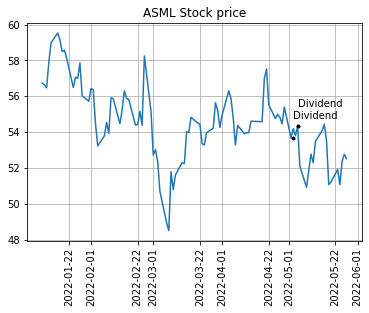

In [499]:
plt.plot('Date', 'Close*', data=ASML_sp)
plt.grid()
plt.title("ASML Stock price")
#plt.annotate("Dividend", (div_date, div_value+10))
#plt.annotate("Dividend", (div_date, div_value+10))
#plt.plot(div_date, div_value, '.', color='black')
for i in range(int(len(d)/3)):
    plt.annotate("Dividend", (d['div_date_{0}'.format(i)], d['div_value_{0}'.format(i)] + d['div_value_{0}'.format(i)]/50))
    plt.plot(d['div_date_{0}'.format(i)], d['div_value_{0}'.format(i)], '.', color='black')
plt.xticks(rotation='90')
plt.show()

In [507]:
hist_stock_price('AAPL')

,Date,Open,High,Low,Close*,Adj Close**,Volume
1,2022-05-27,137.39,146.35,145.26,146.34,146.34,6591817
2,2022-05-26,137.39,144.34,137.14,143.78,143.78,90501100
3,2022-05-25,138.43,141.79,138.34,140.52,140.52,92482700
4,2022-05-24,140.81,141.97,137.33,140.36,140.36,104132700
5,2022-05-23,137.79,143.26,137.65,143.11,143.11,117726300
...,...,...,...,...,...,...,...
96,2022-01-13,175.78,176.62,171.79,172.19,171.72,84505800
97,2022-01-12,176.12,177.18,174.82,175.53,175.05,74805200
98,2022-01-11,172.32,175.18,170.82,175.08,174.60,76138300
99,2022-01-10,169.08,172.50,168.17,172.19,171.72,106765600


In [496]:
def plot_sp(ticker):
    dataset = hist_stock_price(ticker)
    
    d = {}
    for i in range(len(dataset[dataset.Open == 0])):
        d["div_date_{0}".format(i)] = dataset.loc[dataset.Open == 0, 'Date'].iloc[i] #get the date of dividend
        d["div_date_index_{0}".format(i)] = div_date.index[i] #get the index of the dividend line
        d["div_value_{0}".format(i)] = dataset.iloc[div_date_index-2, 5].iloc[i] #get the value at closing of the dividend day
    
    dataset = dataset.drop(dataset[dataset.Open == 0].index) #remove dividend line(s)
    
    #create plot
    plt.plot('Date', 'Close*', data=dataset)
    plt.grid()
    plt.title(str(ticker) + " Stock price")
    for i in range(int(len(d)/3)):
        plt.annotate("Dividend", (d['div_date_{0}'.format(i)], d['div_value_{0}'.format(i)] + d['div_value_{0}'.format(i)]/50))
        plt.plot(d['div_date_{0}'.format(i)], d['div_value_{0}'.format(i)], '.', color='black')
    plt.xticks(rotation='90')
    plt.show()

In [364]:
from dateutil.relativedelta import relativedelta

In [365]:
def to_weekday(timestamp, type='forth'):
    if type == 'back':
        if timestamp.weekday() == 5: #saturday
            timestamp = timestamp - relativedelta(days=+1)
        elif timestamp.weekday() == 6: #sunday
            timestamp = timestamp - relativedelta(days=+2)
        else:
            pass
    elif type == 'forth':
        if timestamp.weekday() == 5: #saturday
            timestamp = timestamp + relativedelta(days=+2)
        elif timestamp.weekday() == 6: #sunday
            timestamp = timestamp + relativedelta(days=+1)
        else:
            pass
    return timestamp

In [366]:
def relative_diff(dataset, months_back=3):
    try:
        m3 = pd.to_datetime('today').floor('D') - relativedelta(months=+months_back)
        m3 = to_weekday(m3)
        
        m2 = m3 + relativedelta(days=+1)
        m2 = to_weekday(m2, 'forth')
        
        m1 = m3 - relativedelta(days=+1)
        m1 = to_weekday(m1, 'back')
        
        old = dataset.loc[(dataset['Date'] > m1) & (dataset['Date'] < m2), 'Close*'].iloc[0] #add iloc to make it a value instead of a Series
        new = dataset.loc[dataset['Date'] > today - relativedelta(days=+1), 'Close*'].iloc[0] #add iloc to make it a value instead of a Series
        
        diff = ((new - old) / old)*100
        diff2 = round(diff, 2)
        
        return print('Relative difference 3 months: ' + str(diff2)+'%' + ' [compared to ' + str(m3.date()) + ']')
    
    except IndexError:
        print("Error: No data available for that period, try a lower number.")

In [368]:
relative_diff(ASML_sp, 2)

Relative difference 3 months: -14.85% [compared to 2022-03-28]
